In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 63.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Sequential, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, BatchNormalization, LeakyReLU, Input, Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import shutil
import random
from PIL import Image
#import pywt

In [ ]:
def load_images_by_category(base_folder):
    categories = ['Normal_coronal', 'Cyst_coronal', 'Tumor_coronal', 'Stone_coronal']
    #categories = ['Normal512x512', 'Cyst512x512', 'Tumor512x512', 'Stone512x512']

    normal_images = []
    cyst_images = []
    tumor_images = []
    stone_images = []

    for category in categories:
        folder_path = os.path.join(base_folder, category)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(folder_path, filename)
                    img = Image.open(img_path).convert("L")  # Convierte a escala de grises (1 canal)
                    if category == 'Normal_coronal':
                        normal_images.append(np.array(img))
                    elif category == 'Cyst_coronal':
                        cyst_images.append(np.array(img))
                    elif category == 'Tumor_coronal':
                        tumor_images.append(np.array(img))
                    elif category == 'Stone_coronal':
                        stone_images.append(np.array(img))

    return normal_images, cyst_images, tumor_images, stone_images


# Preprocesamiento

In [ ]:
base_folder = "/content/drive/MyDrive/TP_Final/dataset_coronal"

normal_images_coronal, cyst_images_coronal, tumor_images_coronal, stone_images_coronal = load_images_by_category(base_folder)

print(f"Imágenes Normales: {len(normal_images_coronal)}")
print(f"Imágenes Cyst: {len(cyst_images_coronal)}")
print(f"Imágenes Tumor: {len(tumor_images_coronal)}")
print(f"Imágenes Stone: {len(stone_images_coronal)}")

# Ver la forma de la primera imagen de cada lista
print(f"Forma primera imagen Normal: {normal_images_coronal[0].shape}")
print(f"Forma primera imagen Cyst: {cyst_images_coronal[0].shape}")
print(f"Forma primera imagen Tumor: {tumor_images_coronal[0].shape}")
print(f"Forma primera imagen Stone: {stone_images_coronal[0].shape}")

Imágenes Normales: 1803
Imágenes Cyst: 1462
Imágenes Tumor: 943
Imágenes Stone: 529
Forma primera imagen Normal: (634, 785)
Forma primera imagen Cyst: (700, 865)
Forma primera imagen Tumor: (961, 1187)
Forma primera imagen Stone: (1001, 1236)


In [ ]:
def ruido_TW(imagen, nivel = 1):
  coeffs = pywt.wavedec2(imagen, 'haar', level=nivel)

  HH = coeffs[-1][2]
  noise_estimation = np.var(HH)

  return noise_estimation

def wavelet_denoising(imagen, max_nivel=3, umbral_multiplicador=1, graficar = False):

  # Estimar la varianza del ruido
  varianza_ruido = ruido_TW(imagen, max_nivel)
    # Calcular el umbral
  umbral = umbral_multiplicador * np.sqrt(varianza_ruido)

    # Realizar la descomposición en wavelets
  coeffs = pywt.wavedec2(imagen, 'haar', level=max_nivel)

    # Aplicar umbralización
  def thresholding(coeffs, umbral):
      new_coeffs = list(coeffs)
      for i in range(1, len(new_coeffs)):
          cH, cV, cD = new_coeffs[i]
          new_coeffs[i] = (pywt.threshold(cH, umbral, mode='soft'),
                            pywt.threshold(cV, umbral, mode='soft'),
                            pywt.threshold(cD, umbral, mode='soft'))
      return new_coeffs

  coeffs_thresh = thresholding(coeffs, umbral)

    # Reconstruir la imagen
  imagen_denoised = pywt.waverec2(coeffs_thresh, 'haar')
  imagen_denoised = np.uint8(np.clip(imagen_denoised, 0, 255))

  if graficar == True:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(imagen, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Imagen Denoised')
    plt.imshow(imagen_denoised, cmap='gray')
    plt.axis('off')

    plt.show()

  return imagen_denoised

In [ ]:
for i in range(len(normal_images_coronal)):
  normal_images_coronal[i] = wavelet_denoising(normal_images_coronal[i])

for i in range(len(cyst_images_coronal)):
  cyst_images_coronal[i] = wavelet_denoising(cyst_images_coronal[i])

for i in range(len(tumor_images_coronal)):
  tumor_images_coronal[i] = wavelet_denoising(tumor_images_coronal[i])

for i in range(len(stone_images_coronal)):
  stone_images_coronal[i] = wavelet_denoising(stone_images_coronal[i])

In [ ]:
def save_images_to_folders(base_folder, image_arrays, categories):
    for images, category in zip(image_arrays, categories):
        folder_path = os.path.join(base_folder, category)
        if os.path.isdir(folder_path):
            print(f"Guardando imágenes en la carpeta: {category}")
            filenames = sorted(os.listdir(folder_path))  # Asegurar que coincidan los nombres
            for img_array, filename in zip(images, filenames):
                if filename.endswith((".png", ".jpg", ".jpeg")):
                    # Convertir el array a imagen PIL en escala de grises
                    img = Image.fromarray(img_array).convert("L")

                    # Guardar la imagen sobrescribiendo la original
                    img.save(os.path.join(folder_path, filename))
            print(f"Imágenes de {category} sobrescritas correctamente.\n")

In [ ]:
# Definir ruta base y categorías
base_folder = "/content/drive/MyDrive/TP_Final/dataset_coronal"
categories = ['Normal_coronal', 'Cyst_coronal', 'Tumor_coronal', 'Stone_coronal']

# Llamada a la función con las listas de imágenes
save_images_to_folders(
    base_folder=base_folder,
    image_arrays=[normal_images_coronal, cyst_images_coronal, tumor_images_coronal, stone_images_coronal],
    categories=categories
)

Guardando imágenes en la carpeta: Normal_coronal
Imágenes de Normal_coronal sobrescritas correctamente.

Guardando imágenes en la carpeta: Cyst_coronal
Imágenes de Cyst_coronal sobrescritas correctamente.

Guardando imágenes en la carpeta: Tumor_coronal
Imágenes de Tumor_coronal sobrescritas correctamente.

Guardando imágenes en la carpeta: Stone_coronal
Imágenes de Stone_coronal sobrescritas correctamente.



# Correr desde aca - Transversal

In [ ]:
base_folder = "/content/drive/MyDrive/TP_Final/dataset512x512"

normal_images, cyst_images, tumor_images, stone_images = load_images_by_category(base_folder)

print(f"Imágenes Normales: {len(normal_images)}")
print(f"Imágenes Cyst: {len(cyst_images)}")
print(f"Imágenes Tumor: {len(tumor_images)}")
print(f"Imágenes Stone: {len(stone_images)}")

# Ver la forma de la primera imagen de cada lista
print(f"Forma primera imagen Normal: {normal_images[0].shape}")
print(f"Forma primera imagen Cyst: {cyst_images[0].shape}")
print(f"Forma primera imagen Tumor: {tumor_images[0].shape}")
print(f"Forma primera imagen Stone: {stone_images[0].shape}")

Imágenes Normales: 3274
Imágenes Cyst: 2247
Imágenes Tumor: 1340
Imágenes Stone: 848
Forma primera imagen Normal: (512, 512)
Forma primera imagen Cyst: (512, 512)
Forma primera imagen Tumor: (512, 512)
Forma primera imagen Stone: (512, 512)


In [ ]:
def split_data(images, train_size=0.7, val_size=0.15, test_size=0.15):
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_size / (test_size + val_size), random_state=42)
    return train_images, val_images, test_images

In [ ]:
normal_train, normal_val, normal_test = split_data(normal_images)
cyst_train, cyst_val, cyst_test = split_data(cyst_images)
tumor_train, tumor_val, tumor_test = split_data(tumor_images)
stone_train, stone_val, stone_test = split_data(stone_images)

print(f"NORMAL:\n Train: {len(normal_train)}, Validation: {len(normal_val)}, Test: {len(normal_test)}")
print(f"CYST:\n Train: {len(cyst_train)}, Validation: {len(cyst_val)}, Test: {len(cyst_test)}")
print(f"STONE:\n Train: {len(tumor_train)}, Validation: {len(tumor_val)}, Test: {len(tumor_test)}")
print(f"TUMOR:\n Train: {len(stone_train)}, Validation: {len(stone_val)}, Test: {len(stone_test)}")

NORMAL:
 Train: 2291, Validation: 491, Test: 492
CYST:
 Train: 1572, Validation: 337, Test: 338
STONE:
 Train: 937, Validation: 201, Test: 202
TUMOR:
 Train: 593, Validation: 127, Test: 128


In [ ]:
# Etiquetas para cada clase
def assign_labels(images, label):
    return [(image, label) for image in images]

In [ ]:
# Asignar etiquetas
train_data = (
    assign_labels(normal_train, 0) +
    assign_labels(cyst_train, 1) +
    assign_labels(tumor_train, 2) +
    assign_labels(stone_train, 3)
)

val_data = (
    assign_labels(normal_val, 0) +
    assign_labels(cyst_val, 1) +
    assign_labels(tumor_val, 2) +
    assign_labels(stone_val, 3)
)

test_data = (
    assign_labels(normal_test, 0) +
    assign_labels(cyst_test, 1) +
    assign_labels(tumor_test, 2) +
    assign_labels(stone_test, 3)
)

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)

# Convertir a arrays de NumPy para usar en TensorFlow
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
def preprocess(image, label):
    IMG_SIZE = 128  # Cambia esto al tamaño deseado
    if len(image.shape) == 2:  # Si la imagen es 2D (height, width)
        image = tf.expand_dims(image, axis=-1)  # Añade el canal de color
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normaliza la imagen a [0, 1]
    label = tf.one_hot(label, depth=4)  # One-hot encoding para las etiquetas (4 clases)
    return image, label

In [ ]:
def create_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Crear datasets para train, val y test
batch_size = 32
train_dataset = create_dataset(train_images, train_labels, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(val_images, val_labels, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(test_images, test_labels, batch_size=batch_size, shuffle=False)

# Correr desde aca - Coronal

In [ ]:
base_folder = "/content/drive/MyDrive/TP_Final/dataset_coronal"

normal_images, cyst_images, tumor_images, stone_images = load_images_by_category(base_folder)

print(f"Imágenes Normales: {len(normal_images)}")
print(f"Imágenes Cyst: {len(cyst_images)}")
print(f"Imágenes Tumor: {len(tumor_images)}")
print(f"Imágenes Stone: {len(stone_images)}")

# Ver la forma de la primera imagen de cada lista
print(f"Forma primera imagen Normal: {normal_images[0].shape}")
print(f"Forma primera imagen Cyst: {cyst_images[0].shape}")
print(f"Forma primera imagen Tumor: {tumor_images[0].shape}")
print(f"Forma primera imagen Stone: {stone_images[0].shape}")

Imágenes Normales: 1803
Imágenes Cyst: 1462
Imágenes Tumor: 943
Imágenes Stone: 529
Forma primera imagen Normal: (692, 854)
Forma primera imagen Cyst: (932, 1152)
Forma primera imagen Tumor: (656, 810)
Forma primera imagen Stone: (1002, 1236)


In [ ]:
def split_data(images, train_size=0.7, val_size=0.15, test_size=0.15):
    train_images, temp_images = train_test_split(images, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_size / (test_size + val_size), random_state=42)
    return train_images, val_images, test_images

In [ ]:
normal_train, normal_val, normal_test = split_data(normal_images)
cyst_train, cyst_val, cyst_test = split_data(cyst_images)
tumor_train, tumor_val, tumor_test = split_data(tumor_images)
stone_train, stone_val, stone_test = split_data(stone_images)

print(f"NORMAL:\n Train: {len(normal_train)}, Validation: {len(normal_val)}, Test: {len(normal_test)}")
print(f"CYST:\n Train: {len(cyst_train)}, Validation: {len(cyst_val)}, Test: {len(cyst_test)}")
print(f"STONE:\n Train: {len(tumor_train)}, Validation: {len(tumor_val)}, Test: {len(tumor_test)}")
print(f"TUMOR:\n Train: {len(stone_train)}, Validation: {len(stone_val)}, Test: {len(stone_test)}")

NORMAL:
 Train: 1262, Validation: 270, Test: 271
CYST:
 Train: 1023, Validation: 219, Test: 220
STONE:
 Train: 660, Validation: 141, Test: 142
TUMOR:
 Train: 370, Validation: 79, Test: 80


In [ ]:
# Etiquetas para cada clase
def assign_labels(images, label):
    return [(image, label) for image in images]

In [ ]:
# Asignar etiquetas
train_data = (
    assign_labels(normal_train, 0) +
    assign_labels(cyst_train, 1) +
    assign_labels(tumor_train, 2) +
    assign_labels(stone_train, 3)
)

val_data = (
    assign_labels(normal_val, 0) +
    assign_labels(cyst_val, 1) +
    assign_labels(tumor_val, 2) +
    assign_labels(stone_val, 3)
)

test_data = (
    assign_labels(normal_test, 0) +
    assign_labels(cyst_test, 1) +
    assign_labels(tumor_test, 2) +
    assign_labels(stone_test, 3)
)

random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)
test_images, test_labels = zip(*test_data)
'''
# Convertir a arrays de NumPy para usar en TensorFlow
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)'''

'\n# Convertir a arrays de NumPy para usar en TensorFlow\ntrain_images = np.array(train_images)\ntrain_labels = np.array(train_labels)\n\nval_images = np.array(val_images)\nval_labels = np.array(val_labels)\n\ntest_images = np.array(test_images)\ntest_labels = np.array(test_labels)'

In [ ]:
def preprocess(image, label):
    IMG_SIZE = 128  # Cambia esto al tamaño deseado
    if len(image.shape) == 2:  # Si la imagen es 2D (height, width)
        image = tf.expand_dims(image, axis=-1)  # Añade el canal de color
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normaliza la imagen a [0, 1]
    label = tf.one_hot(label, depth=4)  # One-hot encoding para las etiquetas (4 clases)
    return image, label

In [ ]:
def create_dataset(images, labels, batch_size=32, shuffle=True):
    images = list(images)
    labels = list(labels)
    for i in range(len(images)):
        images[i], labels[i] = preprocess(images[i], labels[i])
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
# Crear datasets para train, val y test
batch_size = 32
train_dataset = create_dataset(train_images, train_labels, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset(val_images, val_labels, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_images[0].shape)

(702, 870)


# Redes :)

In [ ]:
IMG_SIZE = 128

# Crear modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cbs = [callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', verbose=1, patience=2),
       callbacks.ModelCheckpoint("best_weights.weights.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only = True),
       callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, verbose=1, restore_best_weights=True)]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,508 (24.86 MB)

 Trainable params: 6,516,996 (24.86 MB)

 Non-trainable params: 512 (2.00 KB)

# Evaluar el Modelo

In [ ]:
def calcular_metricas(model, test_dataset):
    y_true = []
    y_pred = []

    # Iterar sobre el test_dataset en lotes
    for images, labels in test_dataset:
        # Predecir las probabilidades para las imágenes en este lote
        y_pred_probs = model.predict(images)

        # Convertir las probabilidades a las clases predichas
        y_pred_batch = np.argmax(y_pred_probs, axis=1)

        # Convertir las etiquetas verdaderas (en one-hot) a enteros
        y_true_batch = np.argmax(labels, axis=1)

        # Acumular las etiquetas verdaderas y las predicciones
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

    # Convertir las listas a arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Cálculo de precisión, recall y demás métricas
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Especificidad por clase
    specificities = []
    for i in range(len(conf_matrix)):
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)

    # Especificidad promedio
    avg_specificity = np.mean(specificities)

    # Evaluación del modelo (loss y accuracy)
    loss, accuracy = model.evaluate(test_dataset)

    # Imprimir métricas
    print("Métricas del modelo:\n")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Average Specificity: {avg_specificity * 100:.2f}%")

    return loss, accuracy, precision, recall, avg_specificity


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def graficar_matriz_confusion(model, test_dataset, labels=None, normalize='true'):
    y_true = []
    y_pred = []

    # Iterar sobre el test_dataset en lotes
    for images, labels_batch in test_dataset:
        # Predecir las probabilidades para las imágenes en este lote
        print(images.shape)
        print(images[0].shape)
        y_pred_probs = model.predict(images)

        # Convertir las probabilidades a las clases predichas
        y_pred_batch = np.argmax(y_pred_probs, axis=1)

        # Convertir las etiquetas verdaderas (en one-hot) a enteros
        y_true_batch = np.argmax(labels_batch, axis=1)

        # Acumular las etiquetas verdaderas y las predicciones
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

    # Convertir las listas a arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format="d")

    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()


##Transversal

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=cbs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8986 - loss: 0.3689
Epoch 1: val_accuracy improved from -inf to 0.99740, saving model to best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8990 - loss: 0.3674 - val_accuracy: 0.9974 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 2: val_accuracy improved from 0.99740 to 1.00000, saving model to best_weights.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 5.4982e-04
Epoch 3: val_accuracy did not improve from 1.00000
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 1.0000 - loss: 5.4936e-04 - val_accuracy: 1.0000 - val_loss: 9.5629e-04 - learning_rate: 0.0010
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.00

In [ ]:
# Guardar el modelo completo (arquitectura + pesos + compilación)
#model.save('modelo_completo_transversal.h5')
model.save('my_model_transversal.keras')

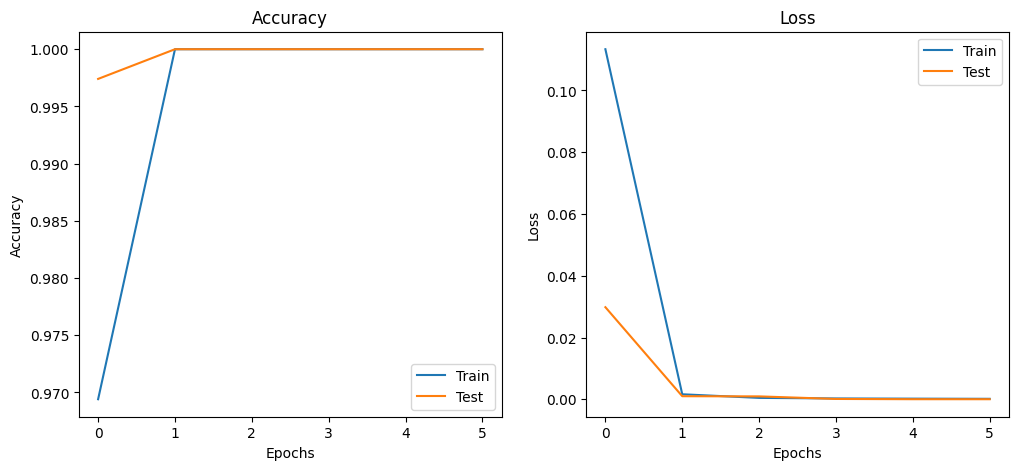

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy, precision, recall, avg_specificity = calcular_metricas(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
[[9.98826683e-01 1.76458052e-04 1.88676320e-04 8.08068318e-04]
 [9.97704387e-01 2.32117251e-04 1.10122550e-03 9.62149294e-04]
 [2.33797964e-05 9.99621212e-01 1.13483948e-04 2.42021517e-04]
 [1.55728285e-05 2.96139060e-05 9.99944270e-01 1.05319195e-05]
 [8.02086288e-05 7.20132157e-05 9.99753118e-01 9.47200897e-05]
 [5.42606358e-06 9.99771595e-01 5.41326372e-05 1.68786515e-04]
 [1.26912624e-07 9.99800205e-01 6.70506561e-05 1.32665635e-04]
 [9.95405495e-01 1.32426758e-05 2.08228783e-04 4.37293528e-03]
 [4.45051191e-05 9.99583900e-01 2.02787181e-04 1.68813916e-04]
 [9.98363376e-01 2.32873412e-04 4.07891377e-04 9.95788840e-04]
 [2.89228160e-06 9.99918759e-01 3.04011024e-07 7.79302063e-05]
 [7.87067165e-06 1.15160792e-05 9.99945462e-01 3.50462287e-05]
 [1.43434647e-06 9.99850512e-01 1.15733637e-04 3.22888191e-05]
 [7.28028972e-05 7.73816719e-04 1.15223600e-04 9.99038160e-01]
 [6.54103451e-06 7.09622225e-04 1.40917706e-04 9.99142885e-01]
 [1.76312369e-05

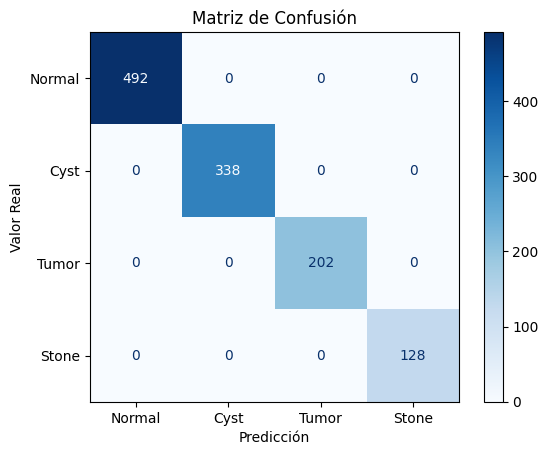

In [ ]:
class_labels = ['Normal', 'Cyst', 'Tumor', 'Stone']
graficar_matriz_confusion(model, test_dataset, class_labels)

##Coronal

In [ ]:
test_images[0].shape

(644, 796)

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=cbs
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8616 - loss: 0.4006
Epoch 1: val_accuracy improved from -inf to 0.98872, saving model to best_weights.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8624 - loss: 0.3984 - val_accuracy: 0.9887 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0048
Epoch 2: val_accuracy improved from 0.98872 to 1.00000, saving model to best_weights.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0022
Epoch 3: val_accuracy did not improve from 1.00000
104/104 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 9

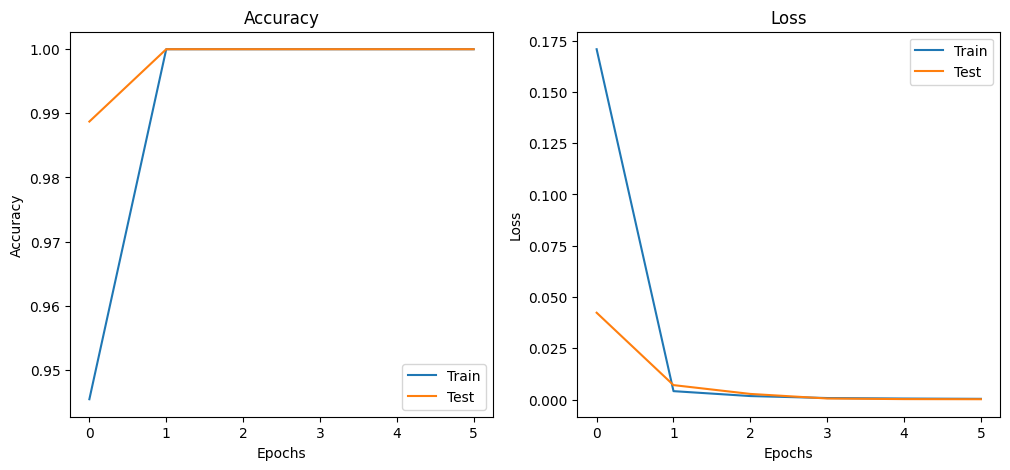

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy, precision, recall, avg_specificity = calcular_metricas(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 1.0000 - loss: 0.0064
Métricas del modelo:

Loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


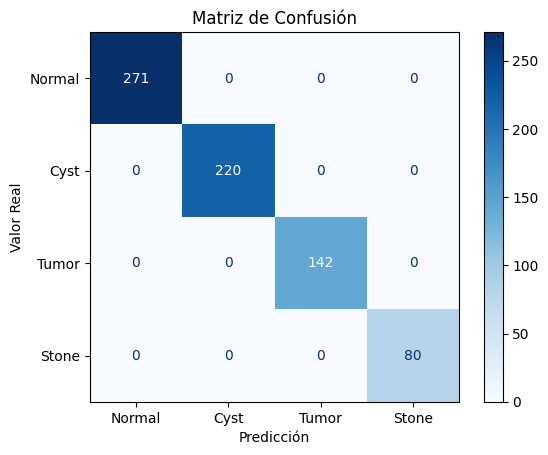

In [ ]:
class_labels = ['Normal', 'Cyst', 'Tumor', 'Stone']
graficar_matriz_confusion(model, test_dataset, class_labels)